In [ ]:
!pip install timm torchmetrics
import timm, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time, os
import json

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [3]:
data_dir = "/kaggle/input/fruit-image-dataset-22-classes/"

# Load dataset once, with dummy transform 
full_dataset = datasets.ImageFolder(root=data_dir)
print("Total images:", len(full_dataset))
print("Classes:", full_dataset.classes)


Total images: 8713
Classes: ['Ripe & Unripe Fruits']


Total images: 8713
Classes: ['ripe apple', 'ripe banana', 'ripe dragon', 'ripe grapes', 'ripe lemon', 'ripe mango', 'ripe orange', 'ripe papaya', 'ripe pineapple', 'ripe pomegranate', 'ripe strawberry', 'unripe apple', 'unripe banana', 'unripe dragon', 'unripe grapes', 'unripe lemon', 'unripe mango', 'unripe orange', 'unripe papaya', 'unripe pineapple', 'unripe pomegranate', 'unripe strawberry']
Train: 6099, Val: 1307, Test: 1307

✅ DataLoaders ready!
Train batches: 191, Val: 41, Test: 41


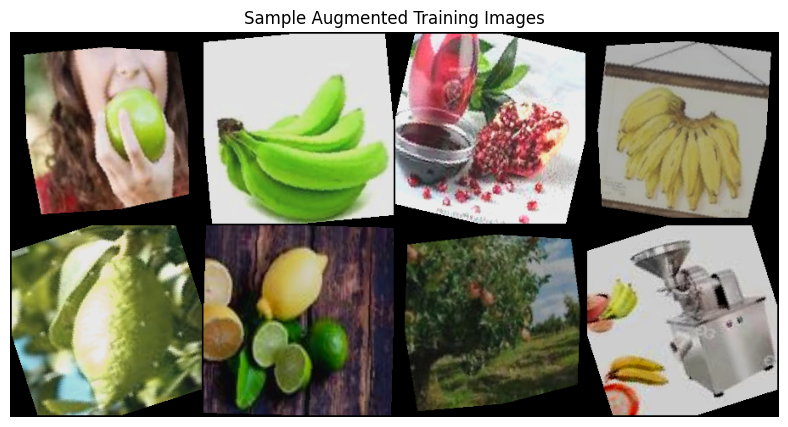

Splits saved at /kaggle/working/split_indices.json


In [8]:
# ================================================================
# Dataset Preparation 
# ================================================================

data_dir = "/kaggle/input/fruit-image-dataset-22-classes/Ripe & Unripe Fruits"

batch_size = 32
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# ================================================================
# Transforms to be applied 
# ================================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomRotation(20),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# ================================================================
# Loading the dataset
# ================================================================
full_dataset = datasets.ImageFolder(root=data_dir)
print("Total images:", len(full_dataset))
print("Classes:", full_dataset.classes)
num_classes = len(full_dataset.classes)

# ================================================================
# Stratified split: 70% train / 15% val / 15% test
# ================================================================
targets = [label for _, label in full_dataset.samples]

train_idx, temp_idx = train_test_split(
    np.arange(len(targets)), test_size=0.30,
    stratify=targets, random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5,
    stratify=np.array(targets)[temp_idx], random_state=42
)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# ================================================================
# Apply transforms 
# ================================================================
class TransformSubset(Dataset):
    """Wraps a Subset to apply a transform dynamically."""
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.subset)

train_subset = Subset(full_dataset, train_idx)
val_subset   = Subset(full_dataset, val_idx)
test_subset  = Subset(full_dataset, test_idx)

train_ds = TransformSubset(train_subset, train_transform)
val_ds   = TransformSubset(val_subset, test_transform)
test_ds  = TransformSubset(test_subset, test_transform)

# ================================================================
# Create DataLoaders
# ================================================================
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

print("\n✅ DataLoaders ready!")
print(f"Train batches: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

# ================================================================
# Visualize augmentations
# ================================================================
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    std=[1/s for s in imagenet_std]
)

imgs, labels = next(iter(train_loader))
imgs = inv_norm(imgs)

grid = torchvision.utils.make_grid(imgs[:8], nrow=4)
plt.figure(figsize=(10,5))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Augmented Training Images")
plt.axis("off")
plt.show()

# ================================================================
# Save split indices (for reproducibility)
# ================================================================
splits = {"train_idx": train_idx.tolist(),
          "val_idx": val_idx.tolist(),
          "test_idx": test_idx.tolist()}

with open("/kaggle/working/split_indices.json", "w") as f:
    json.dump(splits, f)

print("Splits saved at /kaggle/working/split_indices.json")


In [10]:
# ================================================================
#  Model Loader
# ================================================================


def get_model(model_name, num_classes=22):
    """
    Loads a pretrained model from timm and resets the classifier
    to match the number of fruit classes.
    """
    model = timm.create_model(model_name, pretrained=True)
    model.reset_classifier(num_classes)
    return model.to(device)


In [11]:
# ================================================================
# Final Training 
# ================================================================
import shutil
from sklearn.metrics import classification_report

def train_and_evaluate(model_name, epochs=50, lr=3e-4):
    print(f"\n==============================")
    print(f"Training {model_name}")
    print(f"==============================\n")

    # Creating output folders
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    os.makedirs("/kaggle/working/weights", exist_ok=True)

    # Load pretrained model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    best_val_f1 = 0.0
    best_state = None
    history = {"train_loss": [], "val_acc": [], "val_f1": []}
    start_time = time.time()

    for epoch in range(epochs):
        # -------------------- TRAIN --------------------
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # -------------------- VALIDATE --------------------
        model.eval()
        val_preds, val_gts = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(1)
                val_preds.extend(preds.cpu().numpy())
                val_gts.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_gts, val_preds)
        val_f1 = f1_score(val_gts, val_preds, average="macro")
        history["train_loss"].append(running_loss / len(train_loader))
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Loss: {running_loss/len(train_loader):.4f} | "
              f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Save best checkpoint
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict().copy()

    # ================================================================
    # TEST EVALUATION
    # ================================================================
    model.load_state_dict(best_state)
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            preds.extend(out.argmax(1).cpu().numpy())
            gts.extend(labels.cpu().numpy())

    test_acc = accuracy_score(gts, preds)
    test_f1 = f1_score(gts, preds, average="macro")
    cm = confusion_matrix(gts, preds)
    class_report = classification_report(gts, preds, target_names=full_dataset.classes, output_dict=True)

    elapsed = round((time.time() - start_time)/60, 2)
    print(f"\n✅ {model_name} done | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Time: {elapsed} min")

    # ================================================================
    # 💾 SAVE MODEL SAFELY
    # ================================================================
    model_path = f"/kaggle/working/weights/{model_name}_best.pt"
    torch.save(best_state, model_path)
    print(f"✅ Model saved to {model_path}")

    # Also zip all weights
    shutil.make_archive("/kaggle/working/all_model_weights", 'zip', "/kaggle/working/weights")

    # ================================================================
    # SAVE PLOTS
    # ================================================================

    # Training Curves
    epochs_range = range(1, epochs+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss", color="tomato")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{model_name} - Training Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, history["val_acc"], label="Val Accuracy", color="royalblue")
    plt.plot(epochs_range, history["val_f1"], label="Val F1", color="seagreen")
    plt.xlabel("Epoch"); plt.ylabel("Metric"); plt.title(f"{model_name} - Validation Performance")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/plots/{model_name}_training_curves.png", dpi=300)
    plt.show()

    # Confusion Matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/plots/{model_name}_confusion_matrix.png", dpi=300)
    plt.show()

    # Class-wise F1 Plot
    class_f1 = [class_report[c]['f1-score'] for c in full_dataset.classes]
    plt.figure(figsize=(10,6))
    plt.barh(full_dataset.classes, class_f1, color="mediumseagreen")
    plt.title(f"{model_name} - Class-wise F1 Scores")
    plt.xlabel("F1-score")
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/plots/{model_name}_classwise_f1.png", dpi=300)
    plt.show()

    print(f"📊 Plots saved under /kaggle/working/plots/{model_name}_*.png")

    # ================================================================
    # Return summary for comparative analysis
    # ================================================================
    return {
        "Model": model_name,
        "Best Val F1": round(best_val_f1, 4),
        "Test Acc": round(test_acc, 4),
        "Test F1": round(test_f1, 4),
        "Train Time (min)": elapsed
    }



Training mobilenetv2_100



model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Epoch [1/50] | Loss: 2.3525 | Val Acc: 0.5172 | Val F1: 0.5157
Epoch [2/50] | Loss: 1.7051 | Val Acc: 0.5708 | Val F1: 0.5658
Epoch [3/50] | Loss: 1.4980 | Val Acc: 0.5968 | Val F1: 0.5922
Epoch [4/50] | Loss: 1.3393 | Val Acc: 0.6205 | Val F1: 0.6184
Epoch [5/50] | Loss: 1.2188 | Val Acc: 0.6190 | Val F1: 0.6173
Epoch [6/50] | Loss: 1.1360 | Val Acc: 0.6159 | Val F1: 0.6121
Epoch [7/50] | Loss: 1.0697 | Val Acc: 0.6419 | Val F1: 0.6378
Epoch [8/50] | Loss: 1.0199 | Val Acc: 0.6366 | Val F1: 0.6340
Epoch [9/50] | Loss: 0.9816 | Val Acc: 0.6259 | Val F1: 0.6201
Epoch [10/50] | Loss: 0.9480 | Val Acc: 0.6534 | Val F1: 0.6485
Epoch [11/50] | Loss: 0.9153 | Val Acc: 0.6450 | Val F1: 0.6414
Epoch [12/50] | Loss: 0.9037 | Val Acc: 0.6641 | Val F1: 0.6612
Epoch [13/50] | Loss: 0.8901 | Val Acc: 0.6480 | Val F1: 0.6465
Epoch [14/50] | Loss: 0.8682 | Val Acc: 0.6572 | Val F1: 0.6546
Epoch [15/50] | Loss: 0.8599 | Val Acc: 0.6396 | Val F1: 0.6364
Epoch [16/50] | Loss: 0.8468 | Val Acc: 0.6480 | 

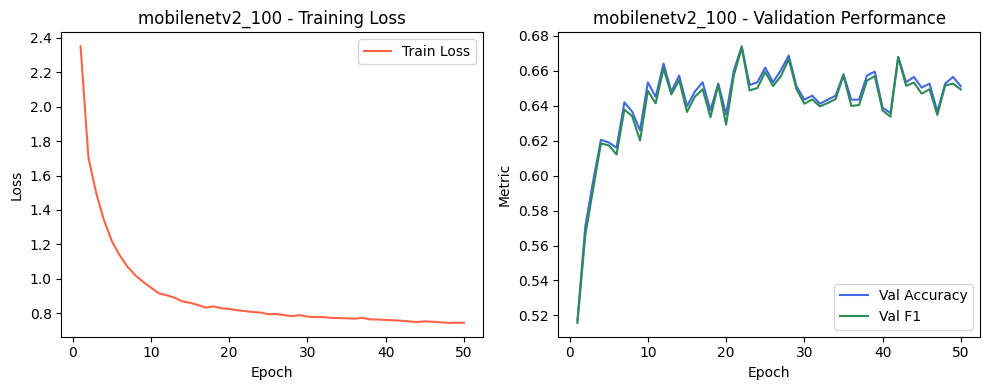

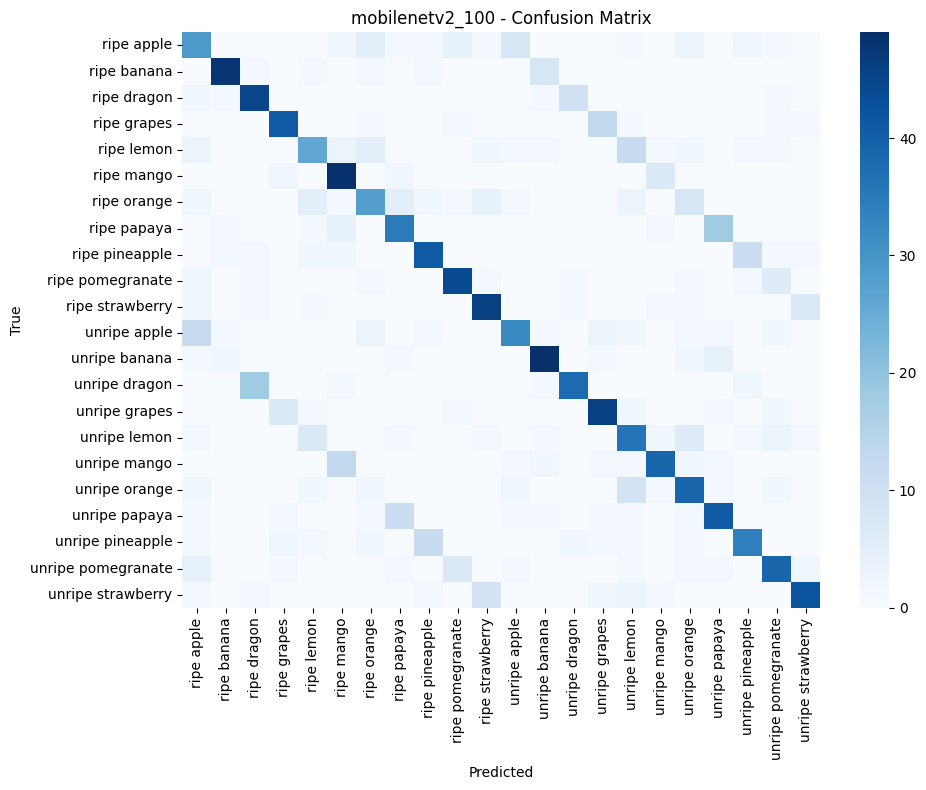

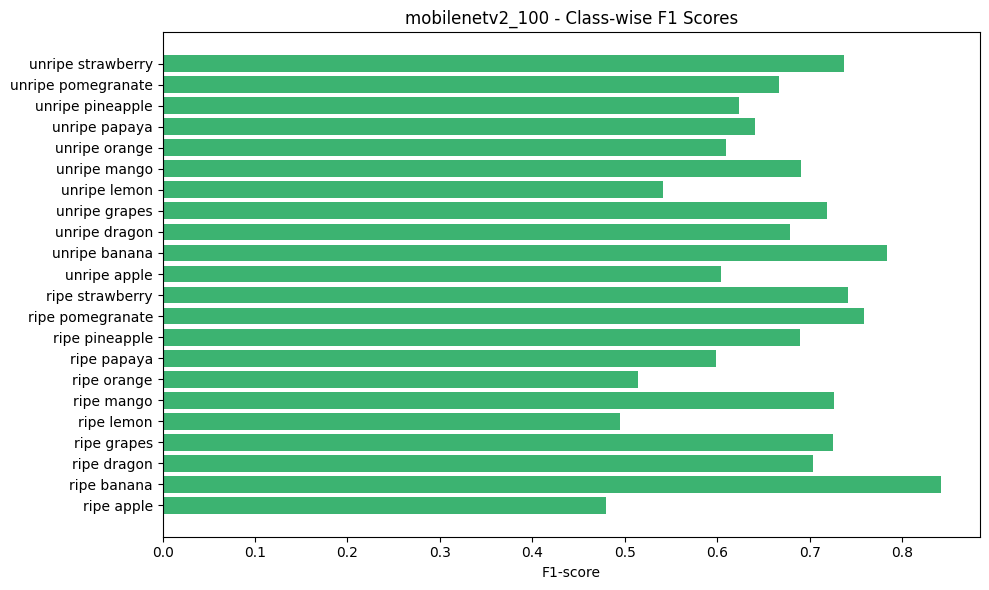

📊 Plots saved under /kaggle/working/plots/mobilenetv2_100_*.png


,Model,Best Val F1,Test Acc,Test F1,Train Time (min)
0,mobilenetv2_100,0.6732,0.6634,0.6621,35.26


In [7]:
# Example: Train and visualize mobilenetv2_100
results = []
metrics = train_and_evaluate("mobilenetv2_100", epochs=50, lr=3e-4)
results.append(metrics)
pd.DataFrame(results)



Training efficientnet_b0



model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch [1/50] | Loss: 2.2550 | Val Acc: 0.5631 | Val F1: 0.5586
Epoch [2/50] | Loss: 1.5180 | Val Acc: 0.6335 | Val F1: 0.6315
Epoch [3/50] | Loss: 1.2368 | Val Acc: 0.6480 | Val F1: 0.6465
Epoch [4/50] | Loss: 1.0883 | Val Acc: 0.6404 | Val F1: 0.6384
Epoch [5/50] | Loss: 0.9869 | Val Acc: 0.6320 | Val F1: 0.6311
Epoch [6/50] | Loss: 0.9345 | Val Acc: 0.6595 | Val F1: 0.6570
Epoch [7/50] | Loss: 0.8933 | Val Acc: 0.6679 | Val F1: 0.6659
Epoch [8/50] | Loss: 0.8626 | Val Acc: 0.6794 | Val F1: 0.6773
Epoch [9/50] | Loss: 0.8416 | Val Acc: 0.6787 | Val F1: 0.6771
Epoch [10/50] | Loss: 0.8264 | Val Acc: 0.6710 | Val F1: 0.6676
Epoch [11/50] | Loss: 0.8170 | Val Acc: 0.6771 | Val F1: 0.6760
Epoch [12/50] | Loss: 0.8102 | Val Acc: 0.6702 | Val F1: 0.6686
Epoch [13/50] | Loss: 0.8016 | Val Acc: 0.6679 | Val F1: 0.6660
Epoch [14/50] | Loss: 0.7904 | Val Acc: 0.6748 | Val F1: 0.6728
Epoch [15/50] | Loss: 0.7854 | Val Acc: 0.6932 | Val F1: 0.6917
Epoch [16/50] | Loss: 0.7802 | Val Acc: 0.6855 | 

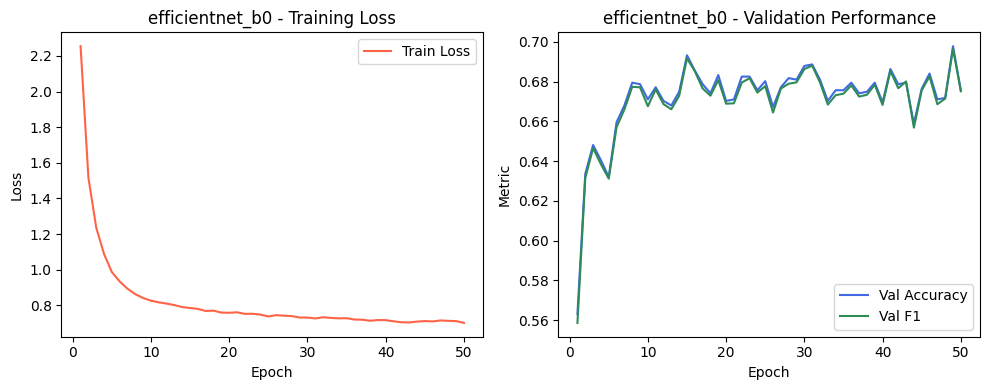

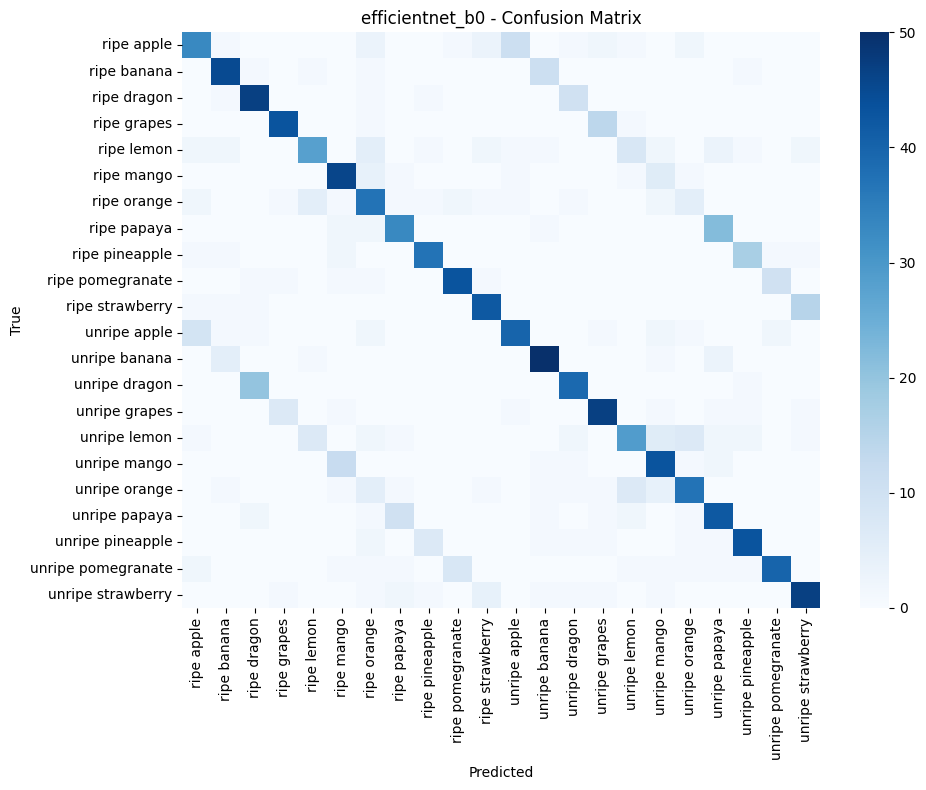

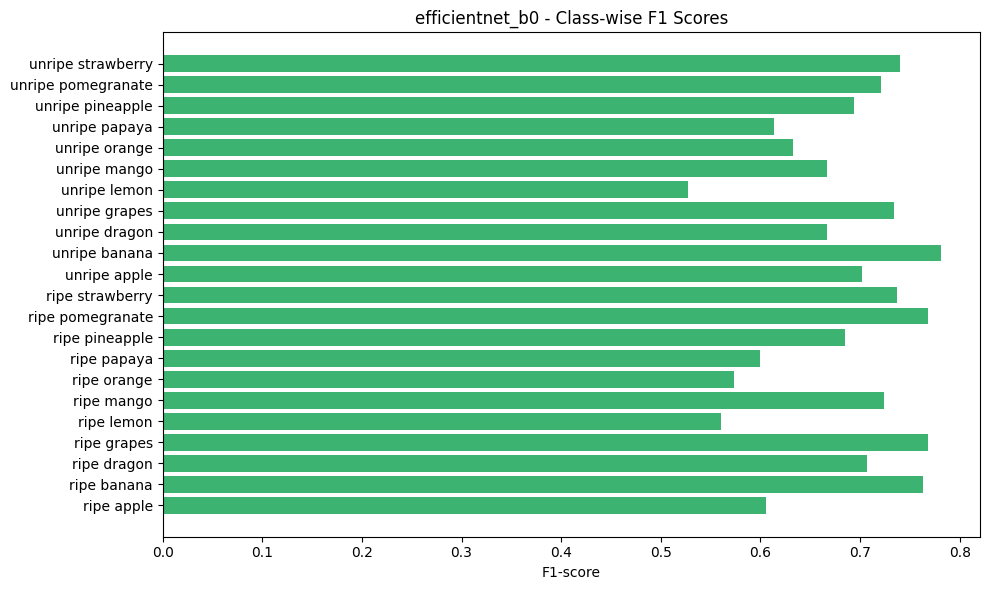

📊 Plots saved under /kaggle/working/plots/efficientnet_b0_*.png


,Model,Best Val F1,Test Acc,Test F1,Train Time (min)
0,efficientnet_b0,0.6964,0.6817,0.6804,35.81


In [8]:
# Train and visualize efficientnet_b0
results = []
metrics = train_and_evaluate("efficientnet_b0", epochs=50, lr=3e-4)
results.append(metrics)
pd.DataFrame(results)



Training resnet50

Epoch [1/50] | Loss: 2.4910 | Val Acc: 0.5463 | Val F1: 0.5324
Epoch [2/50] | Loss: 1.6468 | Val Acc: 0.6588 | Val F1: 0.6563
Epoch [3/50] | Loss: 1.4335 | Val Acc: 0.6725 | Val F1: 0.6707
Epoch [4/50] | Loss: 1.3003 | Val Acc: 0.6894 | Val F1: 0.6892
Epoch [5/50] | Loss: 1.1961 | Val Acc: 0.6917 | Val F1: 0.6902
Epoch [6/50] | Loss: 1.1188 | Val Acc: 0.7016 | Val F1: 0.7001
Epoch [7/50] | Loss: 1.0496 | Val Acc: 0.6963 | Val F1: 0.6951
Epoch [8/50] | Loss: 0.9944 | Val Acc: 0.7016 | Val F1: 0.7007
Epoch [9/50] | Loss: 0.9363 | Val Acc: 0.7016 | Val F1: 0.7010
Epoch [10/50] | Loss: 0.9051 | Val Acc: 0.6871 | Val F1: 0.6858
Epoch [11/50] | Loss: 0.8828 | Val Acc: 0.7085 | Val F1: 0.7079
Epoch [12/50] | Loss: 0.8567 | Val Acc: 0.6886 | Val F1: 0.6867
Epoch [13/50] | Loss: 0.8337 | Val Acc: 0.7054 | Val F1: 0.7050
Epoch [14/50] | Loss: 0.8148 | Val Acc: 0.7016 | Val F1: 0.6999
Epoch [15/50] | Loss: 0.7970 | Val Acc: 0.6894 | Val F1: 0.6884
Epoch [16/50] | Loss: 0.7863 

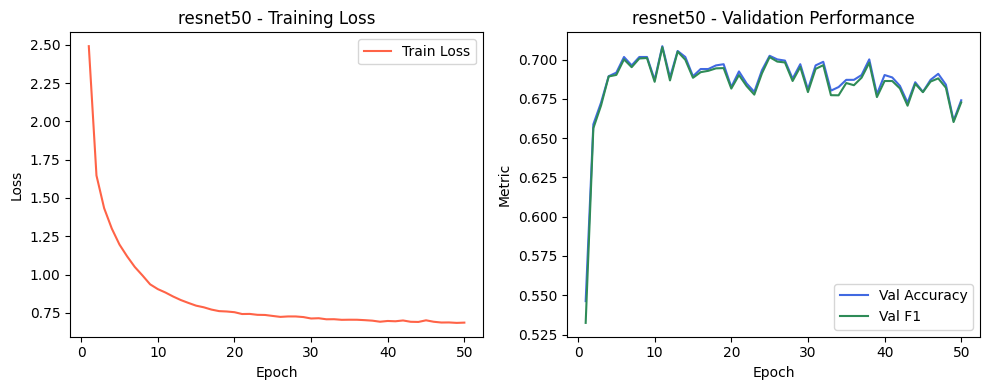

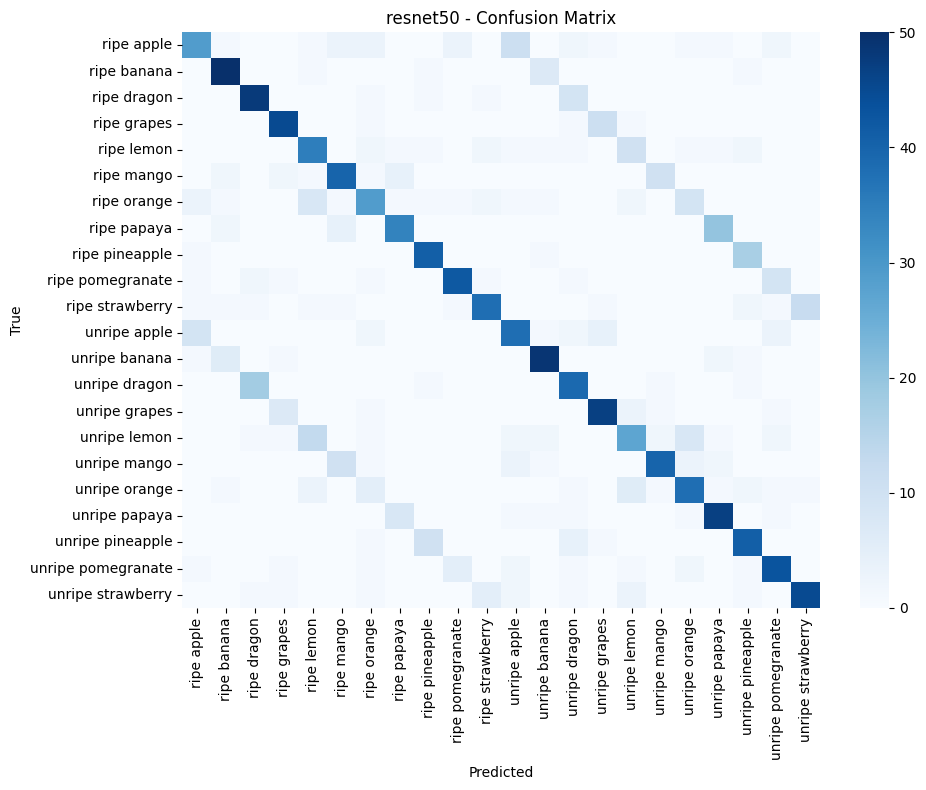

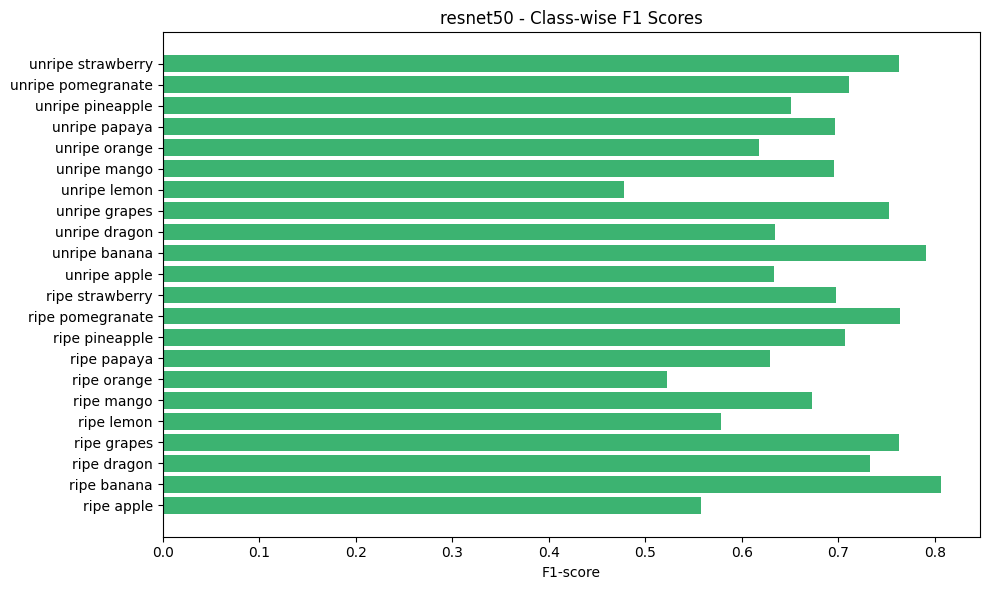

📊 Plots saved under /kaggle/working/plots/resnet50_*.png


,Model,Best Val F1,Test Acc,Test F1,Train Time (min)
0,resnet50,0.7079,0.6771,0.6751,57.91


In [11]:
# Train and visualize ResNet50
results = []
metrics = train_and_evaluate("resnet50", epochs=50, lr=3e-4)
results.append(metrics)
pd.DataFrame(results)



Training vit_base_patch16_224

Epoch [1/50] | Loss: 2.9463 | Val Acc: 0.2295 | Val F1: 0.1624
Epoch [2/50] | Loss: 2.6310 | Val Acc: 0.3053 | Val F1: 0.2764
Epoch [3/50] | Loss: 2.4706 | Val Acc: 0.3252 | Val F1: 0.2976
Epoch [4/50] | Loss: 2.3716 | Val Acc: 0.3588 | Val F1: 0.3315
Epoch [5/50] | Loss: 2.3208 | Val Acc: 0.3650 | Val F1: 0.3601
Epoch [6/50] | Loss: 2.2457 | Val Acc: 0.4285 | Val F1: 0.4155
Epoch [7/50] | Loss: 2.2070 | Val Acc: 0.4024 | Val F1: 0.4006
Epoch [8/50] | Loss: 2.1584 | Val Acc: 0.4200 | Val F1: 0.4151
Epoch [9/50] | Loss: 2.1008 | Val Acc: 0.4170 | Val F1: 0.4210
Epoch [10/50] | Loss: 2.0749 | Val Acc: 0.4384 | Val F1: 0.4309
Epoch [11/50] | Loss: 2.0308 | Val Acc: 0.4606 | Val F1: 0.4532
Epoch [12/50] | Loss: 1.9947 | Val Acc: 0.4996 | Val F1: 0.4952
Epoch [13/50] | Loss: 1.9638 | Val Acc: 0.4774 | Val F1: 0.4706
Epoch [14/50] | Loss: 1.9217 | Val Acc: 0.5256 | Val F1: 0.5183
Epoch [15/50] | Loss: 1.8858 | Val Acc: 0.5050 | Val F1: 0.5025
Epoch [16/50] | L

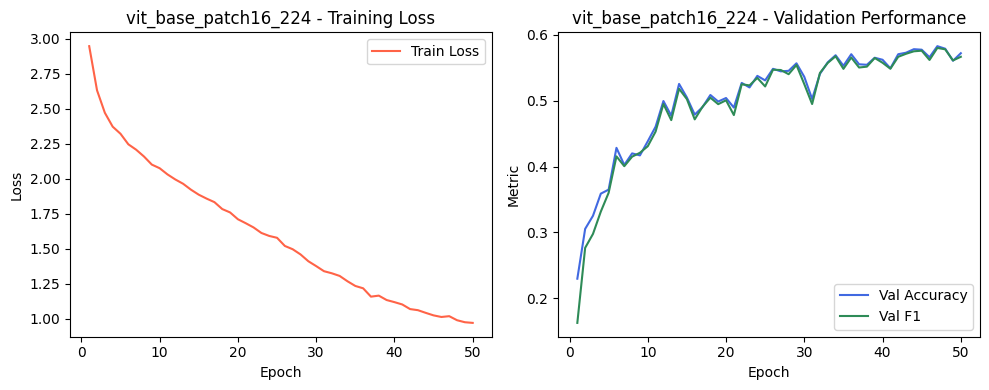

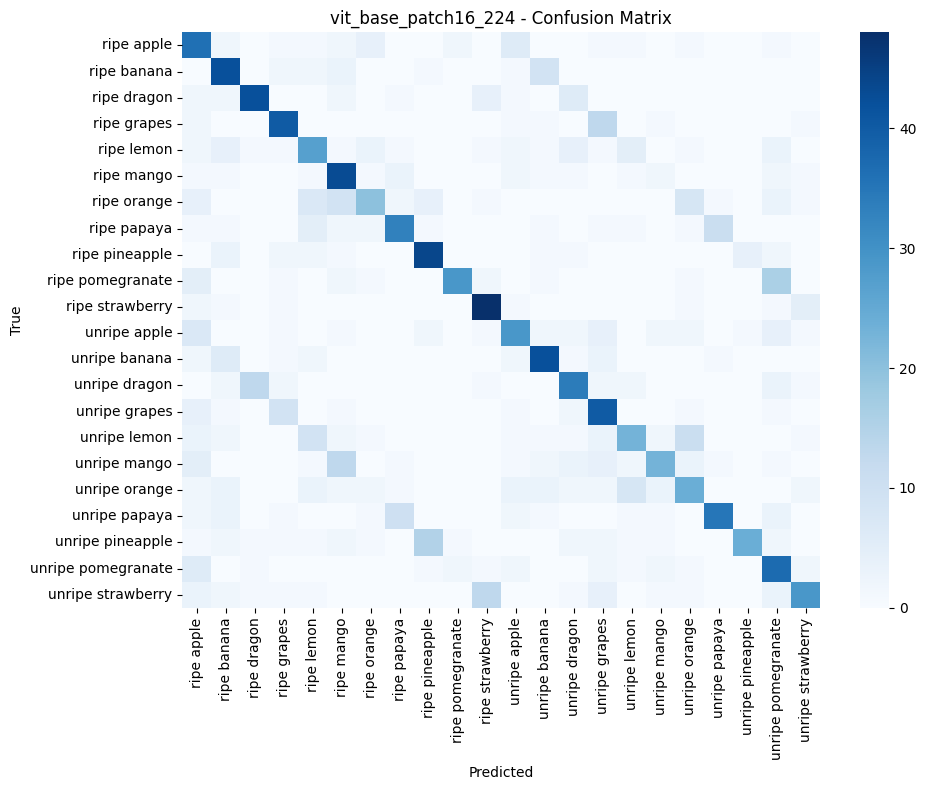

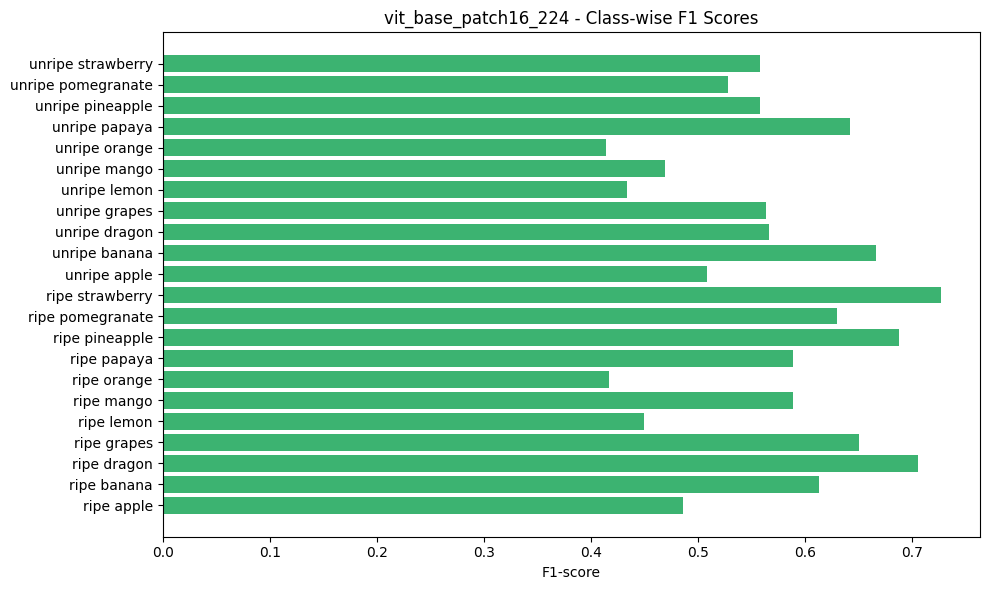

📊 Plots saved under /kaggle/working/plots/vit_base_patch16_224_*.png


,Model,Best Val F1,Test Acc,Test F1,Train Time (min)
0,vit_base_patch16_224,0.5803,0.5692,0.5662,212.91


In [14]:
# Train and visualize ViT
results = []
metrics = train_and_evaluate("vit_base_patch16_224", epochs=50, lr=3e-4)
results.append(metrics)
pd.DataFrame(results)
